This script is for cohort1_opto animals whereby we stimulate fibers either at 0.5s or 5s and see in CC how firing rate changes 

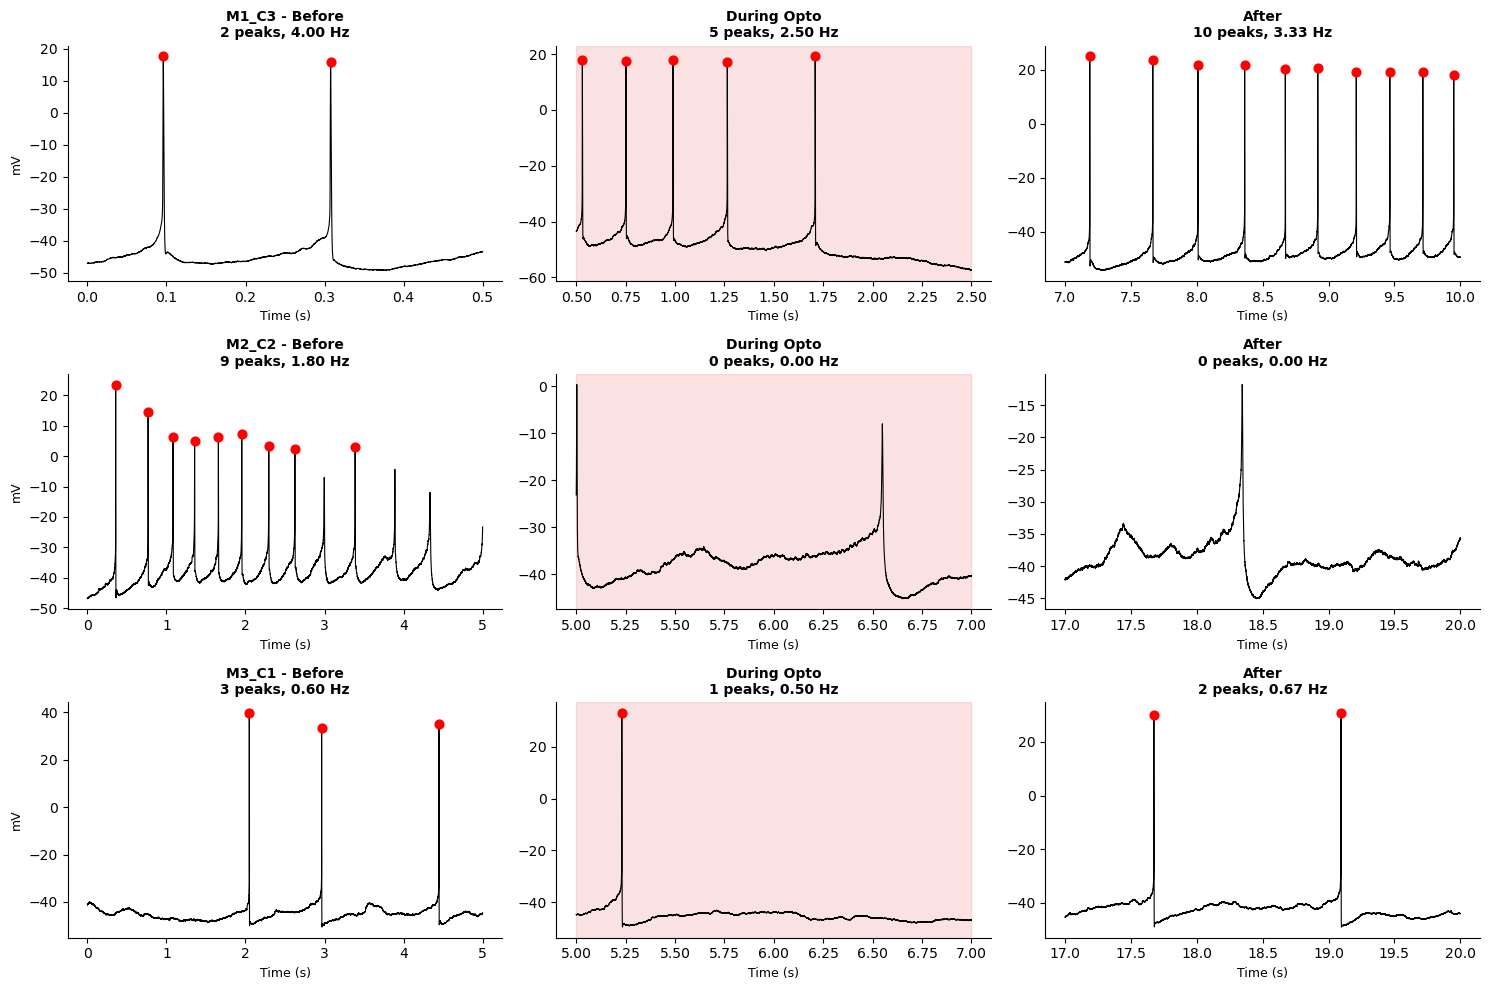


Peak Detection Summary:

M1_C3 (Sweep 0):
  Before: 2 peaks in 0.5s = 4.00 Hz
  During: 5 peaks in 2.0s = 2.50 Hz
  After:   10 peaks in 3.0s = 3.33 Hz

M2_C2 (Sweep 6):
  Before: 9 peaks in 5.0s = 1.80 Hz
  During: 0 peaks in 2.0s = 0.00 Hz
  After:   0 peaks in 3.0s = 0.00 Hz

M3_C1 (Sweep 1):
  Before: 3 peaks in 5.0s = 0.60 Hz
  During: 1 peaks in 2.0s = 0.50 Hz
  After:   2 peaks in 3.0s = 0.67 Hz


In [1]:
import pyabf 
import numpy as np 
import matplotlib.pyplot as plt
from scipy. signal import find_peaks

def detect_peaks(data_array, height_threshold=1, prominence_min=0.1, distance_min=5):
    peaks, properties = find_peaks(
        data_array,
        height=height_threshold,
        prominence=prominence_min,
        distance=distance_min
    )
    return peaks, properties

files_to_check = [
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\11.12.2025 M1\\2025_12_11_0025.abf",
        'opto_start': 0.5,
        'opto_duration': 2.0,
        'cell_id': 'M1_C3',
        'sweep':  0
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M2\\2025_12_12_0008.abf",
        'opto_start': 5.0,
        'opto_duration': 2.0,
        'cell_id': 'M2_C2',
        'sweep': 6
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M3\\2025_12_12_0020.abf",
        'opto_start': 5.0,
        'opto_duration': 2.0,
        'cell_id': 'M3_C1',
        'sweep': 1
    },
]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for idx, file_info in enumerate(files_to_check):
    abf = pyabf.ABF(file_info['file'])
    abf.setSweep(file_info['sweep'])
    time = abf.sweepX
    voltage = abf.sweepY
    
    opto_start = file_info['opto_start']
    opto_duration = file_info['opto_duration']
    after_start = time[-1] - 3.0
    
    before_mask = (time >= 0) & (time < opto_start)
    during_mask = (time >= opto_start) & (time < opto_start + opto_duration)
    after_mask = (time >= after_start) & (time <= time[-1])
    
    before_peaks, _ = detect_peaks(voltage[before_mask])
    during_peaks, _ = detect_peaks(voltage[during_mask])
    after_peaks, _ = detect_peaks(voltage[after_mask])
    
    before_duration = opto_start
    during_duration = opto_duration
    after_duration = 3.0
    
    before_rate = len(before_peaks) / before_duration
    during_rate = len(during_peaks) / during_duration
    after_rate = len(after_peaks) / after_duration
    
    # Plot Before
    ax = axes[idx, 0]
    ax.plot(time[before_mask], voltage[before_mask], 'k-', linewidth=0.8)
    if len(before_peaks) > 0:
        ax.scatter(time[before_mask][before_peaks], voltage[before_mask][before_peaks], 
                  color='red', s=40, zorder=5)
    ax.set_title(f"{file_info['cell_id']} - Before\n{len(before_peaks)} peaks, {before_rate:.2f} Hz", 
                fontsize=10, fontweight='bold')
    ax.set_ylabel('mV', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Plot During
    ax = axes[idx, 1]
    ax.plot(time[during_mask], voltage[during_mask], 'k-', linewidth=0.8)
    if len(during_peaks) > 0:
        ax.scatter(time[during_mask][during_peaks], voltage[during_mask][during_peaks], 
                  color='red', s=40, zorder=5)
    ax.axvspan(opto_start, opto_start + opto_duration, color='#EB6F6F', alpha=0.2, zorder=0)
    ax.set_title(f"During Opto\n{len(during_peaks)} peaks, {during_rate:.2f} Hz", 
                fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Plot After
    ax = axes[idx, 2]
    ax.plot(time[after_mask], voltage[after_mask], 'k-', linewidth=0.8)
    if len(after_peaks) > 0:
        ax.scatter(time[after_mask][after_peaks], voltage[after_mask][after_peaks], 
                  color='red', s=40, zorder=5)
    ax.set_title(f"After\n{len(after_peaks)} peaks, {after_rate:.2f} Hz", 
                fontsize=10, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for col in range(3):
        axes[idx, col].set_xlabel('Time (s)', fontsize=9)

plt.tight_layout()
plt.savefig('peak_detection_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPeak Detection Summary:")
print("="*60)
for file_info in files_to_check:
    abf = pyabf.ABF(file_info['file'])
    abf.setSweep(file_info['sweep'])
    time = abf.sweepX
    voltage = abf.sweepY
    
    opto_start = file_info['opto_start']
    opto_duration = file_info['opto_duration']
    after_start = time[-1] - 3.0
    
    before_mask = (time >= 0) & (time < opto_start)
    during_mask = (time >= opto_start) & (time < opto_start + opto_duration)
    after_mask = (time >= after_start) & (time <= time[-1])
    
    before_peaks, _ = detect_peaks(voltage[before_mask])
    during_peaks, _ = detect_peaks(voltage[during_mask])
    after_peaks, _ = detect_peaks(voltage[after_mask])
    
    print(f"\n{file_info['cell_id']} (Sweep {file_info['sweep']}):")
    print(f"  Before: {len(before_peaks)} peaks in {opto_start:.1f}s = {len(before_peaks)/opto_start:.2f} Hz")
    print(f"  During: {len(during_peaks)} peaks in {opto_duration:.1f}s = {len(during_peaks)/opto_duration:.2f} Hz")
    print(f"  After:   {len(after_peaks)} peaks in 3.0s = {len(after_peaks)/3.0:.2f} Hz")

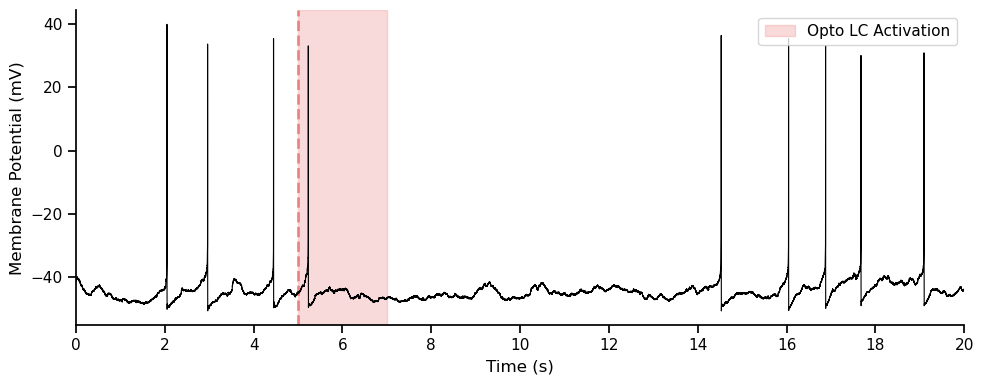

In [2]:
"""
This script plots a single CC recording showing spiking in response to injected CC (with opto modulation)
"""
import pyabf 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import seaborn as sns
sns.set_context('notebook')

# Load your ABF file
base_dir = "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1"
abf = pyabf.ABF(os.path.join(base_dir, "12.12.2025 M3/2025_12_12_0020.abf"))

# Select sweep (or average multiple sweeps)
abf.setSweep(1)  # Change sweep number as needed
time = abf.sweepX
voltage = abf.sweepY


# ============== Plot: ==============
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot(time, voltage, color='black', linewidth=0.8)
# Add shaded region to highlight opto period
opto_start = 5  # seconds
opto_duration = 2.0  # seconds
ax1.axvspan(opto_start, opto_start + opto_duration, 
            color='#EB6F6F', alpha=0.25, label='Opto LC Activation', zorder=0)

# Add vertical line at opto onset
ax1.axvline(x=opto_start, color='#EB6F6F', linestyle='--', 
            linewidth=2, alpha=0.8, zorder=1)

# Formatting
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Membrane Potential (mV)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Clean x-axis formatting
time_max = np.ceil(time.max())
ax1.set_xlim([0, time_max])
ax1.xaxis.set_major_locator(MultipleLocator(2.0)) 
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

Processing M1_C3...
Processing M1_C3...
Processing M2_C2...
Processing M3_C1...

Analyzed 35 sweeps from 3 cells
         before_opto  during_opto  after_opto
cell_id                                      
M1_C3       3.300000     1.850000    1.216667
M2_C2       0.514286     0.357143    0.095238
M3_C1       0.400000     0.125000    0.333333


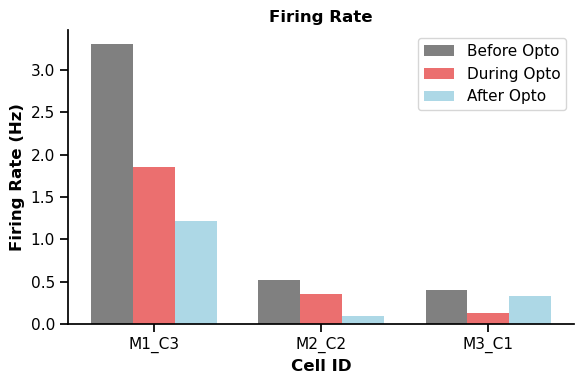

In [3]:
"""
Analyze firing rate before, during, and after opto stimulation.
Calculates firing rates for each phase and stores them for plotting.
"""
from ephys_functions import detect_peaks
import pyabf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_firing_rates(abf_file, opto_start, opto_duration, cell_id):
    """
    Calculate firing rates before, during, and after opto stimulation.
    Parameters:
    - abf_file: path to ABF file
    - opto_start: time when opto starts (seconds)
    - opto_duration: duration of opto stimulation (seconds)
    - cell_id: identifier for this cell (e.g., "M3_C1")
    Returns:
    - dict with firing rates for each phase
    """
    abf = pyabf.ABF(abf_file)
    results = []
    
    # Process each sweep
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        time = abf.sweepX
        voltage = abf.sweepY
        
        # Define time windows
        before_mask = (time >= 0) & (time < opto_start)
        during_mask = (time >= opto_start) & (time < opto_start + opto_duration)
        
        # After opto: choosing last 3 seconds to allow for recovery of spiking
        after_start = time[-1] - 3.0  # Last 3 seconds
        after_mask = (time >= after_start) & (time <= time[-1])
        
        # Calculate duration of each phase
        before_duration = opto_start
        during_duration = opto_duration
        after_duration = 3.0  # Fixed 3 seconds
        
        # Detect spikes in each phase
        before_peaks, _ = detect_peaks(voltage[before_mask])
        during_peaks, _ = detect_peaks(voltage[during_mask])
        after_peaks, _ = detect_peaks(voltage[after_mask])
        
        # Calculate firing rates (Hz)
        before_rate = len(before_peaks) / before_duration if before_duration > 0 else 0
        during_rate = len(during_peaks) / during_duration if during_duration > 0 else 0
        after_rate = len(after_peaks) / after_duration if after_duration > 0 else 0
        
        results.append({
            'cell_id': cell_id,
            'sweep': sweep,
            'before_opto': before_rate,
            'during_opto': during_rate,
            'after_opto': after_rate
        })
    
    return results

# ==================== MAIN ANALYSIS ====================

# List your files with their parameters
files_to_analyze = [
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\11.12.2025 M1\\2025_12_11_0025.abf",
        
        'opto_start': 0.5,  # seconds
        'opto_duration': 2.0,  # seconds
        'cell_id': 'M1_C3'
    },
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\11.12.2025 M1\\2025_12_11_0028.abf",
        'opto_start': 0.5,
        'opto_duration': 2.0,
        'cell_id': 'M1_C3'
    },
    
    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M2/2025_12_12_0008.abf",
        'opto_start': 5.0,
        'opto_duration': 2.0,
        'cell_id': 'M2_C2'
    },

    {
        'file': "Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\Opto_Cohort1\\12.12.2025 M3/2025_12_12_0020.abf",
        'opto_start': 5.0,
        'opto_duration': 2.0,
        'cell_id': 'M3_C1'
    },
]

# Collect all results
all_results = []

for file_info in files_to_analyze:
    print(f"Processing {file_info['cell_id']}...")
    results = calculate_firing_rates(
        abf_file=file_info['file'],
        opto_start=file_info['opto_start'],
        opto_duration=file_info['opto_duration'],
        cell_id=file_info['cell_id']
    )
    all_results.extend(results)

# Convert to DataFrame
df = pd.DataFrame(all_results)
print(f"\nAnalyzed {len(df)} sweeps from {df['cell_id'].nunique()} cells")
print(df.groupby('cell_id')[['before_opto', 'during_opto', 'after_opto']].mean())

# ==================== PLOTTING ====================

# Calculate mean per cell
cell_means = df.groupby('cell_id')[['before_opto', 'during_opto', 'after_opto']].mean().reset_index()

# Create bar plot
fig, ax = plt.subplots(figsize=(6, 4))

x = np.arange(len(cell_means))
width = 0.25

bars1 = ax.bar(x - width, cell_means['before_opto'], width, label='Before Opto', color='gray')
bars2 = ax.bar(x, cell_means['during_opto'], width, label='During Opto', color='#EB6F6F')
bars3 = ax.bar(x + width, cell_means['after_opto'], width, label='After Opto', color='lightblue')

ax.set_xlabel('Cell ID', fontweight='bold')
ax.set_ylabel('Firing Rate (Hz)', fontweight='bold')
ax.set_title('Firing Rate', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(cell_means['cell_id'])
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()



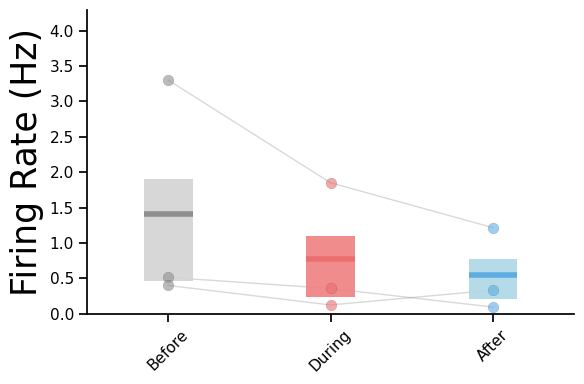

In [4]:
## Same plot but boxplot with connected lines 

# Color scheme matching your example
colors = ['lightgrey', 'lightcoral', 'lightblue']
colors_bar = ["#908E8E", "#EB6F6F", "#5DADE2"]

fig, ax = plt.subplots(figsize=(6, 4))

conditions = ['Before', 'During', 'After']
box_data = [
    cell_means['before_opto'].values,
    cell_means['during_opto'].values,
    cell_means['after_opto'].values
]

# Plot boxplots
box = ax.boxplot(
    box_data,
    positions=range(3),
    widths=0.3,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color='none'),
    boxprops=dict(facecolor='none', edgecolor='none'),
    whiskerprops=dict(color='none'),
    capprops=dict(color='none')
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.9)

# Plot connected lines and points
for _, row in cell_means.iterrows():
    y = [row['before_opto'], row['during_opto'], row['after_opto']]
    x = [0, 1, 2]
    
    # Connect points with line
    ax.plot(x, y, color='gray', alpha=0.3, linewidth=1, zorder=1)
    
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.scatter(xi, yi, color=colors_bar[i], alpha=0.6, s=60, zorder=2,
                  edgecolors='black', linewidths=0.1)

# Draw mean lines
box_width = 0.3
for i, col in enumerate(['before_opto', 'during_opto', 'after_opto']):
    y_vals = cell_means[col].values
    ax.hlines(np.mean(y_vals), i - box_width/2, i + box_width/2,
             color=colors_bar[i], linewidth=4, zorder=3)

# Format axes
max_y = cell_means[['before_opto', 'during_opto', 'after_opto']].max().max()
ax.set_ylabel('Firing Rate (Hz)', fontsize=25)
ax.set_xticks(range(3))
ax.set_xticklabels(conditions, rotation=45)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, max_y + (max_y * 0.3))

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Baseline-Normalized Firing Rates:
   cell_id  baseline_norm  during_normalized  after_normalized
0    M1_C3            1.0           0.625000          0.833333
1    M1_C3            1.0           0.375000          0.250000
2    M1_C3            1.0           0.375000          0.083333
3    M1_C3            1.0           0.250000          0.000000
4    M1_C3            1.0           0.583333          0.555556
5    M1_C3            1.0           1.000000          0.500000
6    M1_C3            1.0           0.500000          0.333333
7    M1_C3            1.0           0.500000          0.000000
8    M1_C3            1.0           0.375000          0.000000
9    M1_C3            1.0           0.375000          0.000000
10   M1_C3            1.0           1.000000          1.000000
11   M1_C3            1.0           0.125000          0.666667
12   M1_C3            1.0                inf               inf
13   M1_C3            1.0           0.250000          0.666667
14   M1_C3           

c:\Users\rbondare\AppData\Local\miniforge3\envs\ephys\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


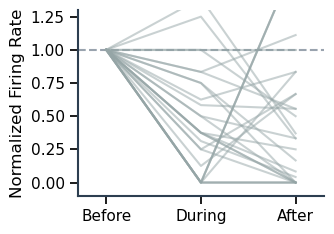

In [6]:
# ==================== BASELINE NORMALIZATION AND PLOTTING ====================
# Normalize to baseline (baseline = 1.0)
df['baseline_norm'] = 1.0
df['during_normalized'] = df['during_opto'] / df['before_opto']
df['after_normalized'] = df['after_opto'] / df['before_opto']

# Print normalized values
print("Baseline-Normalized Firing Rates:")
print(df[['cell_id', 'baseline_norm', 'during_normalized', 'after_normalized']])
print(f"\nMean ± SEM:")
print(f"During: {df['during_normalized'].mean():.3f} ± {df['during_normalized'].sem():.3f}")
print(f"After:  {df['after_normalized'].mean():.3f} ± {df['after_normalized'].sem():.3f}")

# Create figure with white background
fig, ax = plt.subplots(figsize=(3.5, 2.5), facecolor='white')
ax.set_facecolor('white')

# Calculate mean and SEM for shaded area
mean_values = [
    df['baseline_norm'].mean(),
    df['during_normalized'].mean(),
    df['after_normalized'].mean()
]
sem_values = [
    df['baseline_norm'].sem(),
    df['during_normalized'].sem(),
    df['after_normalized'].sem()
]

timepoints = [0, 1, 2]

# Plot individual cell trajectories first (grey, thin, transparent)
for idx, row in df.iterrows():
    values = [row['baseline_norm'], row['during_normalized'], row['after_normalized']]
    
    ax.plot(timepoints, values, 
            color='#95A5A6', 
            linewidth=1.5, 
            alpha=0.5,
            zorder=5)

# Plot shaded SEM area around mean
upper_bound = [m + s for m, s in zip(mean_values, sem_values)]
lower_bound = [m - s for m, s in zip(mean_values, sem_values)]
ax.fill_between(timepoints, lower_bound, upper_bound, 
                alpha=0.2, color='#E74C3C', linewidth=0, zorder=8)

# Plot mean trajectory (thick red line)
ax.plot(timepoints, mean_values, 
        color='#E74C3C', 
        linewidth=3, 
        label='Mean ± SEM',
        zorder=10)

# Reference line at 1.0 (no change from baseline)
ax.axhline(1.0, color='#34495E', linestyle='--', linewidth=1.5, alpha=0.5, zorder=2)

# Styling
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Before', 'During', 'After'])
ax.set_ylabel('Normalized Firing Rate')
ax.set_xlim(-0.3, 2.3)
ax.set_ylim(-0.1, 1.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('#2C3E50')
ax.spines['bottom'].set_color('#2C3E50')

plt.tight_layout()
plt.show()

